# Modeling Food Serving Sizes Through Nutrition Profiles

### Notebook 2 - EDA

## Table of Contents

1. [Importing Packages](#Importing-Packages)
2. [Reading Data](#Reading-Data)
3. [EDA/Visualization](#EDA/Visualization)
    1. [Bar Charts](#Bar-Charts)
    2. [Distributions](#Distributions)
    3. [Scatterplots](#Scatterplots)
    4. [Vectorizing Ingredients](#Vectorizing-Ingredients)
4. [Sources](#Sources)

## Importing Packages

In [3]:
# general tools/visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# imports for NLP
import regex as re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer

# making the magic happen for plots
%matplotlib inline

# setting options for better viewing
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_colwidth", 100)

## Reading Data

From this point forward, we are going to utilize the combined and cleaned dataset from the end of the previous notebook.

In [4]:
foods = pd.read_csv("../datasets/clean_foods_df.csv")

In [5]:
foods.head()

,fdc_id,brand_owner,branded_food_category,description,ingredients,serving_size,household_serving_fulltext,energy,fat_total,fat_sat,fat_trans,chol,protein,carbs,fiber,sugars,sodium
0,356425,"G. T. Japan, Inc.",Ice Cream & Frozen Yogurt,MOCHI ICE CREAM BONBONS,"ICE CREAM INGREDIENTS: MILK, CREAM, SUGAR, STRAWBERRIES (STRAWBERRIES, SUGAR), CORN SYRUP SOLIDS...",40.0,1 PIECE,200.0,6.25,3.75,0.0,25.0,2.5,35.00,0.0,30.00,75.0
1,356426,FRESH & EASY,"Ketchup, Mustard, BBQ & Cheese Sauce",CHIPOTLE BARBECUE SAUCE,"WATER, SUGAR, TOMATO PASTE, MOLASSES, DISTILLED VINEGAR, CONTAINS 2% OR LESS OF: CORN STARCH, SA...",37.0,2 Tbsp,162.0,0.00,0.00,0.0,0.0,0.0,43.24,0.0,37.84,703.0
2,356427,FRESH & EASY,"Ketchup, Mustard, BBQ & Cheese Sauce",HOT & SPICY BARBECUE SAUCE,"SUGAR, WATER, DISTILLED VINEGAR, TOMATO PASTE, MOLASSES, MODIFIED CORN STARCH, SALT, PINEAPPLE J...",34.0,2 Tbsp,176.0,0.00,0.00,0.0,0.0,0.0,41.18,0.0,35.29,676.0
3,356428,FRESH & EASY,"Ketchup, Mustard, BBQ & Cheese Sauce",BARBECUE SAUCE,"TOMATO PUREE (WATER, TOMATO PASTE), SUGAR, DISTILLED VINEGAR, MOLASSES, WATER, MODIFIED CORN STA...",35.0,2 Tbsp,143.0,0.00,0.00,0.0,0.0,0.0,34.29,0.0,28.57,971.0
4,356429,FRESH & EASY,"Ketchup, Mustard, BBQ & Cheese Sauce",BARBECUE SAUCE,"SUGAR, DISTILLED VINEGAR, WATER, TOMATO PASTE, HONEY, MOLASSES, MODIFIED CORN STARCH, SALT, CONT...",37.0,2 Tbsp,189.0,0.00,0.00,0.0,0.0,0.0,45.95,0.0,43.24,757.0


## EDA/Visualization

To help with some of the visualization in the EDA step, it would be helpful to have a function for creating common charts.

In [6]:
# making func for top 10 of whatever counts we need
def top_10(df, col, title, x_lab, y_lab=None, x_tick=None):
    plt.figure(figsize=(10, 8))
    df[col].value_counts(ascending=True).tail(10).plot(kind="barh")
    plt.title(title, size=20)
    plt.xlabel(x_lab, size=15)
    plt.ylabel(y_lab, size=15)
    plt.xticks(x_tick)

In [7]:
# making func for scatterplots
def scatter_plot(df, x_col, y_col, title, x_lab=None, y_lab=None, x_tick=None, y_tick=None):
    plt.figure(figsize=(10, 7))
    plt.scatter(df[x_col], df[y_col])
    plt.title(title, size=20)
    plt.xlabel(x_lab, size=15)
    plt.ylabel(y_lab, size=15)
    plt.xticks(x_tick)
    plt.yticks(y_tick)

In [8]:
# making func for dist plots
def dist_plot(df, col, title, x_lab, x_tick=None, bins=None):
    plt.figure(figsize=(9, 6))
    plt.hist(df[col], bins=bins)
    plt.title(title, size=20)
    plt.xlabel(x_lab, size=15)
    plt.ylabel("Frequency", size=15)
    plt.xticks(x_tick)

One of the first things we can look at in terms of visualizing out data is the see if any of the columns already have a strong correlation with our target of `serving_size`, or even with each other. We can use Seaborn's heatmap 

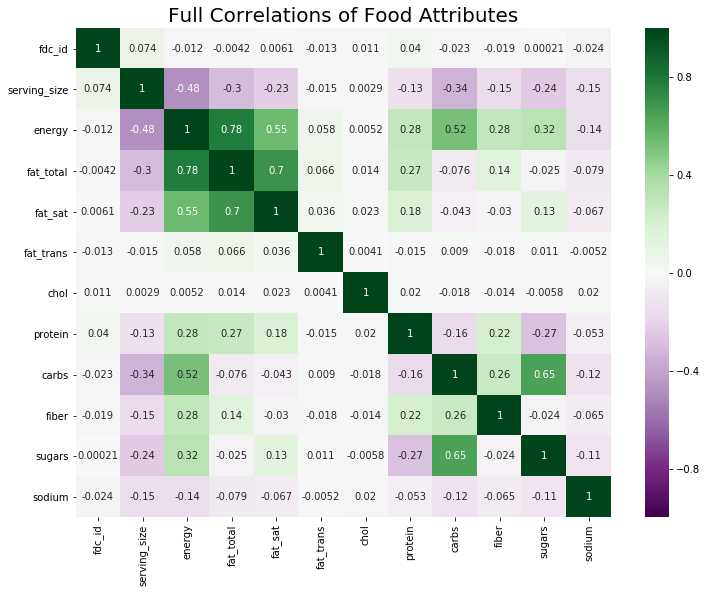

In [9]:
# making heatmap of correlations
plt.figure(figsize=(12, 9))
sns.heatmap(foods.corr(), vmax=1, vmin=-1, cmap="PRGn", annot=True)
plt.title("Full Correlations of Food Attributes", size=20);

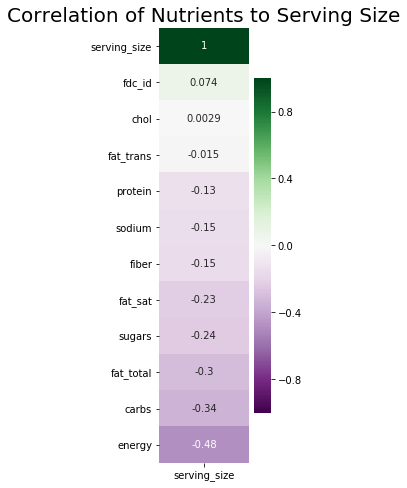

In [10]:
# making heatmap of correlations
plt.figure(figsize=(2, 8))
sns.heatmap(foods.corr()[["serving_size"]].sort_values(by="serving_size", ascending=False),
            vmax=1,vmin=-1,cmap="PRGn",annot=True)
plt.title("Correlation of Nutrients to Serving Size", size=20);

None of the current nutrition features apear to be very highly correlated with the serving size target, though most have a slightly negative correlation. The best single indicator seems to be energy, with a negative correlation of -0.48. The direction of this correlation does appear to make sense, as foods with very high caloric densities probably have smaller serving sizes to keep the calories-per-serving within a reasonable range.

There is, however, some higher correlation between some of the features, particularly between total fat and saturated fat, and between carbohydrates and sugar. This correlation is expected, as in both cases the latter is a subset of the former, so there should be a connection between them. We also see correlations between fats and carbohyrates with energy. This also is somewhat expected, as we know that these two macronutrients are part of the main sources of calories for any food. However, as the sub-categories of these macronutrients are not necessarily the full breakdown of those macronutrients, we cannot determine that these columns are showing multicolinearity.

### Bar Charts

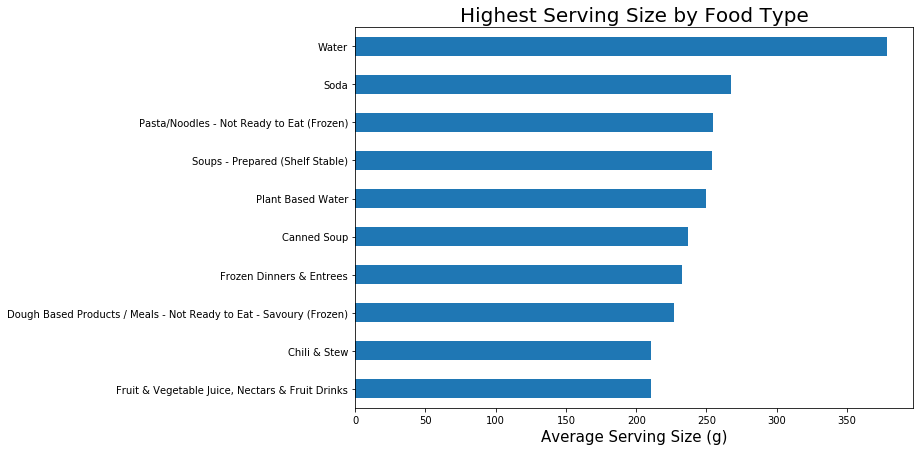

In [21]:
plt.figure(figsize=(10, 7))
foods.groupby("branded_food_category")["serving_size"].mean().sort_values().tail(10).plot(kind="barh")
plt.title("Highest Serving Size by Food Type", size=20)
plt.xlabel("Average Serving Size (g)", size=15)
plt.ylabel(None);

Here we see the which food categories have the highest serving sizes

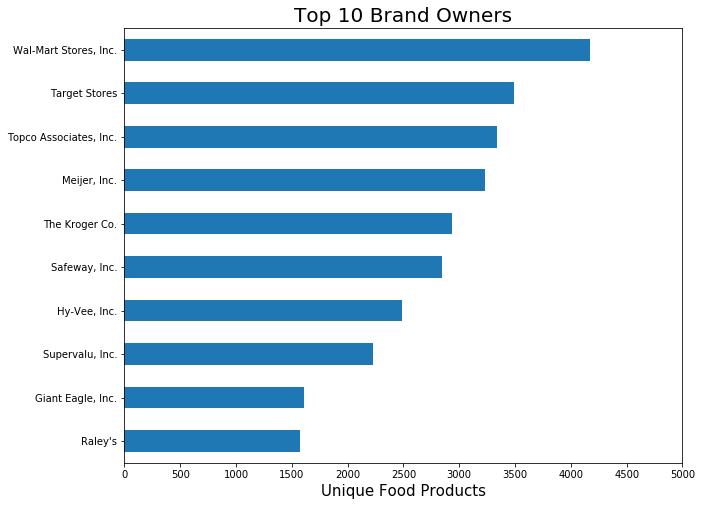

In [12]:
# plotting number of food products per owner
top_10(foods,
       "brand_owner",
       title="Top 10 Brand Owners",
       x_lab="Unique Food Products",
      x_tick=range(0, 5001, 500))

We see from this chart that the top brand owners are large national chains of supermarkets. This is not unexpected because supermarket chains typically have their own brands of foods, and these can range the entire variety of food products that are offered within the store. As Fortune recently named Wal-Mart the largest company in the world by revenue<sup>(1)</sup>. Concentrating within these companies, there may be some visisble trends in serving sizes.

Text(0.5, 0, 'Average Serving Size (g)')

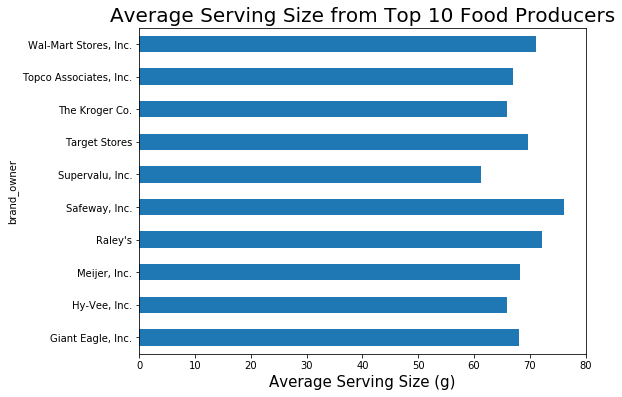

In [13]:
# making a list of the top 10 brand owners
top_brands = foods["brand_owner"].value_counts(ascending=False).head(10).index

# isolating top companies
top_companies = foods[foods["brand_owner"].isin(top_brands)]

# finding the average serv_size of their products
plt.figure(figsize=(8, 6))
foods[foods["brand_owner"].isin(top_brands)].groupby("brand_owner")["serving_size"].mean().plot(kind="barh")
plt.title("Average Serving Size from Top 10 Food Producers", size=20)
plt.xlabel("Average Serving Size (g)", size=15)

With an average serving size of around 64g, we see a similar numbers in the top 10 brand producers, with most of the serving size averages being around the overall mean. The highest of this group seems to be Safeway, with an average of nearly 80g per serving, and the lowest is Supervalu, with close to 60g. Alone, this does not seem to tell us much, but there might be more information as we look into what kinds of foods are in this dataset.

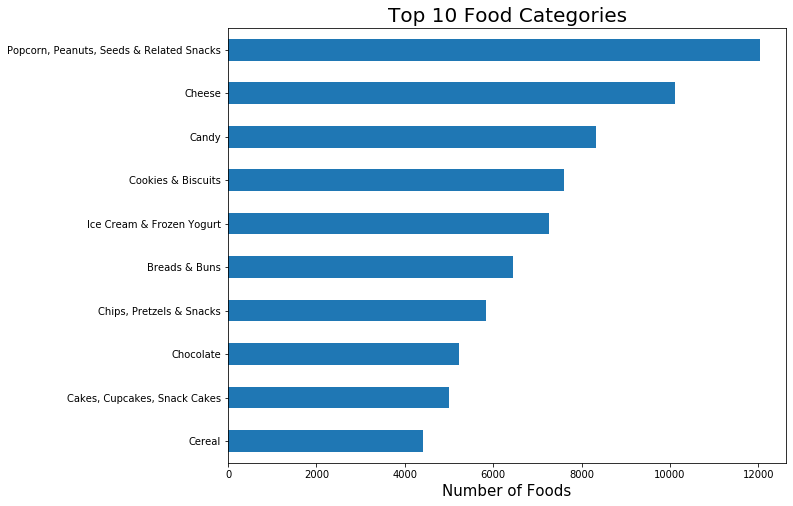

In [14]:
top_10(foods,
       col="branded_food_category",
       title="Top 10 Food Categories",
       x_lab="Number of Foods")

We can see from this chart that most of the food items are snacks and desserts. Many of these items are most likely owned by those top ten companies from the previous chart. 

We can make something of an intersection between this chart and the previous one to see if there is a specific trend in the food categories of Safeway's products.

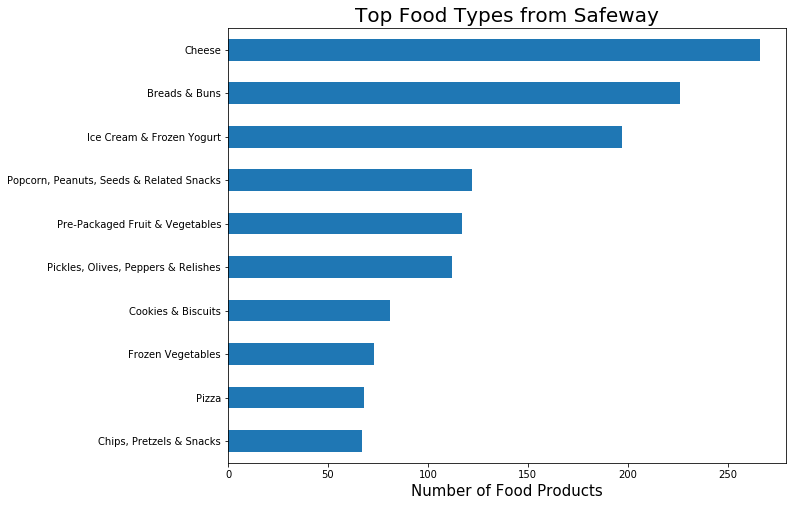

In [15]:
top_10(foods[foods["brand_owner"] == "Safeway, Inc."] ,
      "branded_food_category",
      title="Top Food Types from Safeway",
      x_lab="Number of Food Products")

We can see here that the top product types from Safeway are most likely high in calories, with categories like cheese, and ice cream. It is actually somewhat counterintuitive that these would be giving high serving sizes, so this might not be telling the whole story. We are going to see what the highest serving sizes are within Safeway's products.

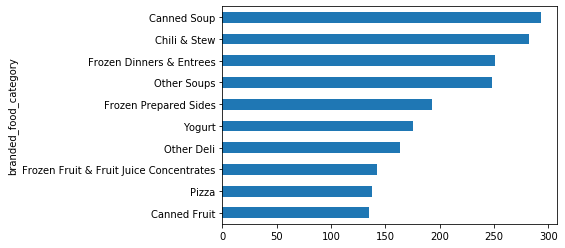

In [19]:
# saving 
safeway_top_servings = foods[foods["brand_owner"] == "Safeway, Inc."].groupby(
    "branded_food_category")["serving_size"].mean().sort_values(ascending=True).tail(10)

safeway_top_servings.plot(kind="barh")

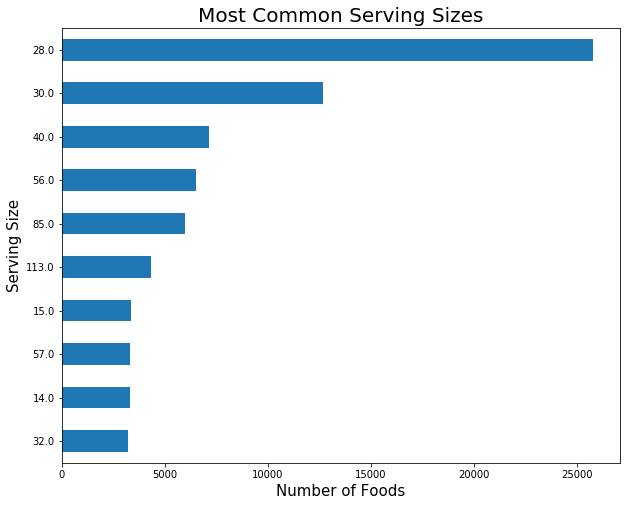

In [42]:
top_10(foods,
       "serving_size",
       title="Most Common Serving Sizes",
       x_lab="Number of Foods",
       y_lab="Serving Size")

Showing the top ten most common serving sizes shows us a low number of 28.0 grams. There are many 

### Distributions

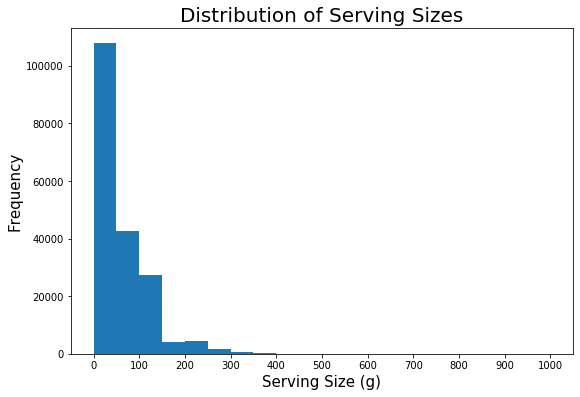

In [43]:
dist_plot(foods,
          col="serving_size",
          title="Distribution of Serving Sizes",
          x_lab="Serving Size (g)",
          x_tick=range(0, 1001, 100),
          bins=20)

The serving sizes of this dataset are heavily skewed to the lower end, with the vast majority of foods having servings sizes between 0 and 50 grams. In terms of predicting this value, it may be helpful to our model to have this column transformed as a log-value.

In [47]:
# adding col for log-servings
foods["log_serv"] = np.log(foods["serving_size"])

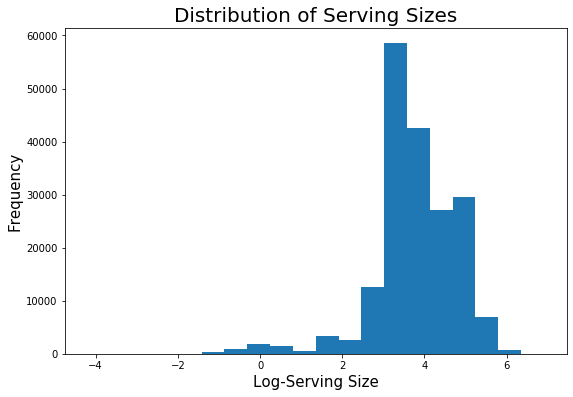

In [48]:
dist_plot(foods,
          col="log_serv",
         title="Distribution of Serving Sizes",
         x_lab="Log-Serving Size",
         bins=20)

While we now have a left tailed distribution, it is much more even that the original histogram above. This should prove to be an effective trasnformation of the target.

Here we see a large mix of servings sizes being very common among our food set. 

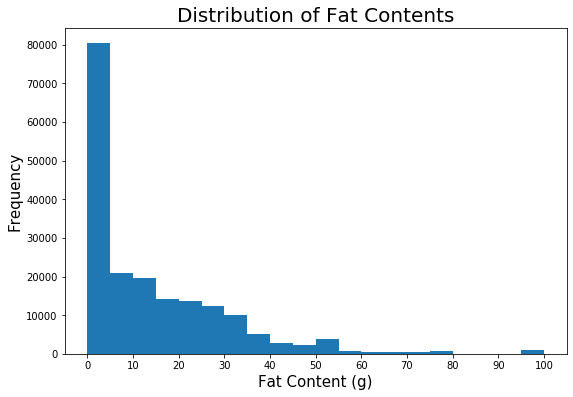

In [50]:
dist_plot(foods,
         col="fat_total",
         title="Distribution of Fat Contents",
         x_lab="Fat Content (g)",
         bins=20,
         x_tick=range(0, 101, 10))

This is an interesting chart, showing that by a huge margin, most of the food prodcuts in this database have no fat in them. Given what we saw in terms of the top categories of our foods, mostly being snacks and desserts, it is surprising that by far the most common entry for fat content is 0. However, going down the list after this first entry, we see some very high fat contents showing up. We saw above that the mean fat content for these foods is around 12g per 100g of food, and most of these are well above that average.

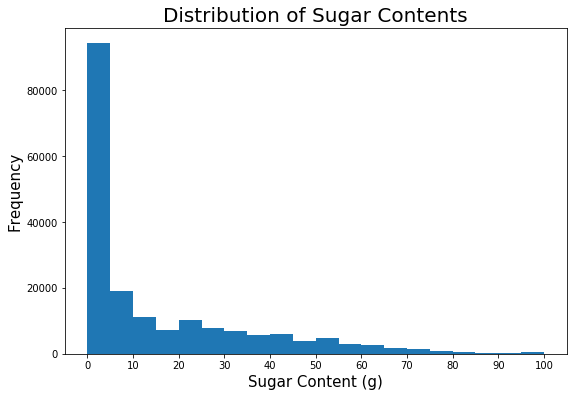

In [51]:
dist_plot(foods,
         col="sugars",
         x_lab="Sugar Content (g)",
         title="Distribution of Sugar Contents",
         x_tick=range(0, 101, 10),
         bins=20)

As with the fat contents, the wide majority of food products have little to no sugar in them

### Scatterplots

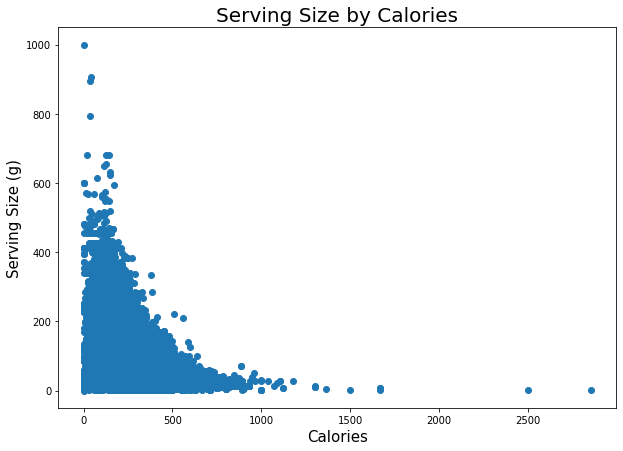

In [52]:
scatter_plot(df=foods,
             y_col="serving_size",
             x_col="energy",
             title="Serving Size by Calories",
            y_lab="Serving Size (g)",
            x_lab="Calories")
#             x_tick=range(0, 101, 10))

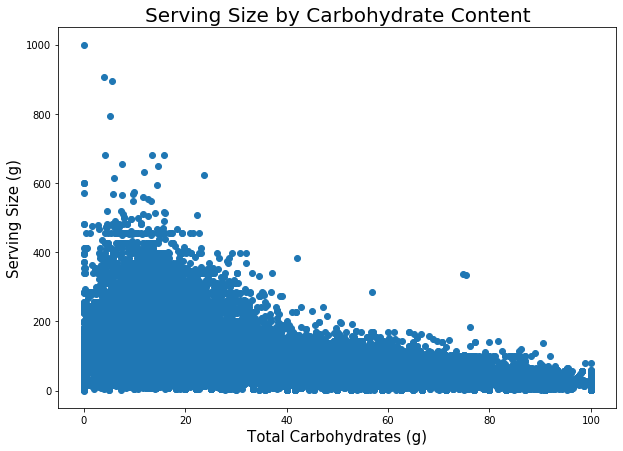

In [53]:
scatter_plot(df=foods,
             x_col="carbs",
             y_col="serving_size",
             title="Serving Size by Carbohydrate Content",
            x_lab="Total Carbohydrates (g)",
            y_lab="Serving Size (g)")
#             x_tick=range(0, 101, 10))

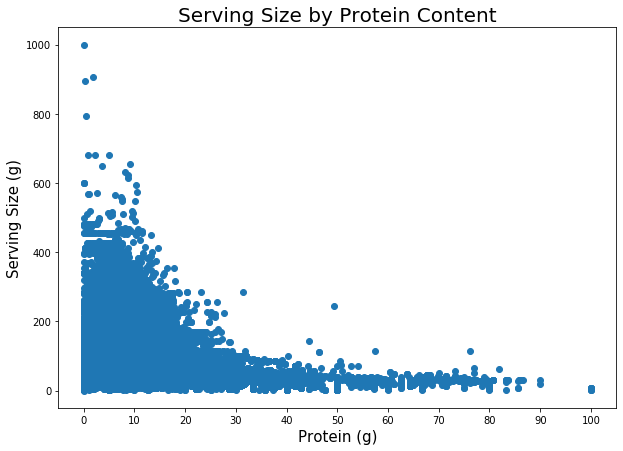

In [54]:
scatter_plot(df=foods,
             x_col="protein",
             y_col="serving_size",
             title="Serving Size by Protein Content",
            x_lab="Protein (g)",
            y_lab="Serving Size (g)",
            x_tick=range(0, 101, 10))

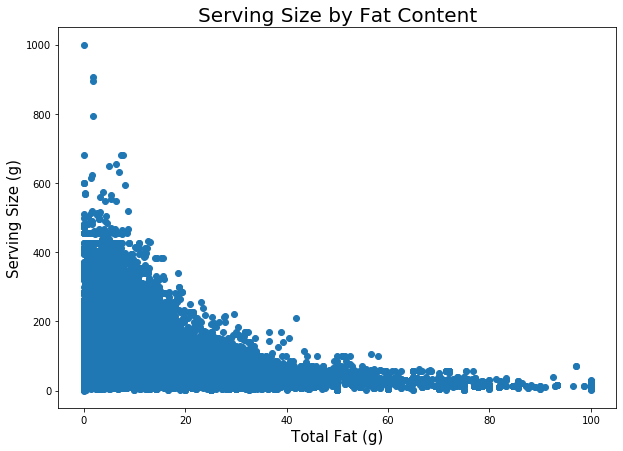

In [55]:
scatter_plot(df=foods,
             x_col="fat_total",
             y_col="serving_size",
             title="Serving Size by Fat Content",
            x_lab="Total Fat (g)",
            y_lab="Serving Size (g)")
#             x_tick=range(0, 101, 10))

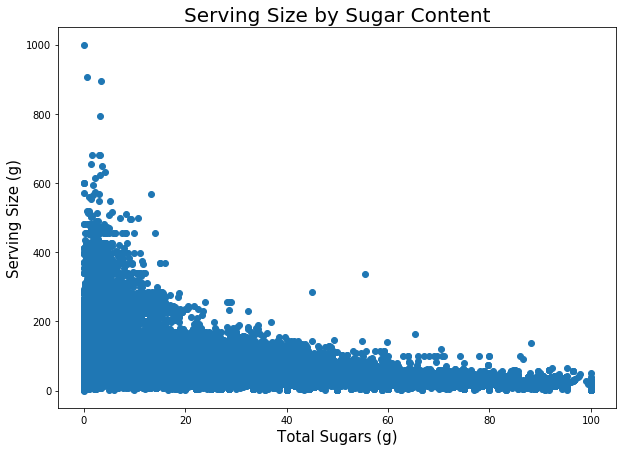

In [56]:
scatter_plot(df=foods,
             x_col="sugars",
             y_col="serving_size",
             title="Serving Size by Sugar Content",
             x_lab="Total Sugars (g)",
             y_lab="Serving Size (g)")

In [57]:
foods.head()

,fdc_id,brand_owner,branded_food_category,description,ingredients,serving_size,household_serving_fulltext,energy,fat_total,fat_sat,fat_trans,chol,protein,carbs,fiber,sugars,sodium,log_serv
0,356425,"G. T. Japan, Inc.",Ice Cream & Frozen Yogurt,MOCHI ICE CREAM BONBONS,"ICE CREAM INGREDIENTS: MILK, CREAM, SUGAR, STRAWBERRIES (STRAWBERRIES, SUGAR), CORN SYRUP SOLIDS...",40.0,1 PIECE,200.0,6.25,3.75,0.0,25.0,2.5,35.00,0.0,30.00,75.0,3.688879
1,356426,FRESH & EASY,"Ketchup, Mustard, BBQ & Cheese Sauce",CHIPOTLE BARBECUE SAUCE,"WATER, SUGAR, TOMATO PASTE, MOLASSES, DISTILLED VINEGAR, CONTAINS 2% OR LESS OF: CORN STARCH, SA...",37.0,2 Tbsp,162.0,0.00,0.00,0.0,0.0,0.0,43.24,0.0,37.84,703.0,3.610918
2,356427,FRESH & EASY,"Ketchup, Mustard, BBQ & Cheese Sauce",HOT & SPICY BARBECUE SAUCE,"SUGAR, WATER, DISTILLED VINEGAR, TOMATO PASTE, MOLASSES, MODIFIED CORN STARCH, SALT, PINEAPPLE J...",34.0,2 Tbsp,176.0,0.00,0.00,0.0,0.0,0.0,41.18,0.0,35.29,676.0,3.526361
3,356428,FRESH & EASY,"Ketchup, Mustard, BBQ & Cheese Sauce",BARBECUE SAUCE,"TOMATO PUREE (WATER, TOMATO PASTE), SUGAR, DISTILLED VINEGAR, MOLASSES, WATER, MODIFIED CORN STA...",35.0,2 Tbsp,143.0,0.00,0.00,0.0,0.0,0.0,34.29,0.0,28.57,971.0,3.555348
4,356429,FRESH & EASY,"Ketchup, Mustard, BBQ & Cheese Sauce",BARBECUE SAUCE,"SUGAR, DISTILLED VINEGAR, WATER, TOMATO PASTE, HONEY, MOLASSES, MODIFIED CORN STARCH, SALT, CONT...",37.0,2 Tbsp,189.0,0.00,0.00,0.0,0.0,0.0,45.95,0.0,43.24,757.0,3.610918


### Vectorizing Ingredients

As ingredients lists have to meet strict legal regulations, they are already somewhat standardized. Therefore, we should need minimal processing when dealing with these entries. Since each ingrient is separated by a comma, we can simply separate on those commas, and vectorize the text in between them. Instances where ingredients are expanded or qualified with further text or ingredients wrapped in parentheses, it still makes sense to group them together as a single entry, as they should be consistently utilized across different foods. 

We will be forgoing the removal as stopwords, since the ingredients are already in lists, and not written out in sentences. While there is some appearance of natural language in the lists, such as "Less than 2% of", they will not be removed at this stage in the project.

Food products are many times made up of multiple sub-foods, and when making ingredient lists, the ingredients of those subfoods are also rquired to be listed. These sub-ingredient lists can become extremely complex, and were proving to be too much for our vectorizer to handle. Because of this, any sub-ingredient lists are going to be removed. In order to do this, we are going to create a function that utilizes regex to find parentheses, and remove any text within them. This will remove the sub-ingredient lists but leave the top-level food name as an ingredient in the original product.

In [58]:
# making func to remove sub-ings
def remove_parens(ings):
    # finding paren sections, subbing with blanks
    return re.sub(" ?\([^)]+\)", "", ings)

In [59]:
# removing parens entries
foods["ingredients"] = foods["ingredients"].apply(lambda x: remove_parens(x))

After this step, we want to remove any further punctuation, such as periods at the ends of the lists. We still want to keep commas, however, as we are going to utilize them in the next step.

In [60]:
# making func to remove non-comma punc, non alpha-num chars
def remove_punc(ings):
    # finding unwanted chars, subbing with blanks
    return re.sub(pattern="[^ ,a-zA-Z0-9\[\]]",
       repl= "",
       string=ings)

In [61]:
# removing unwanted punc
foods["ingredients"] = foods["ingredients"].apply(lambda x: remove_punc(x))

Now that we have formatted the ingredients to be a bit more simplified, we can vectorize, and present them in a dataframe. Since all of our ingredients are separated by commas, we can use that as the delimeter in the vectorizer.

In [63]:
# making func to split on commas
def cust_tokens(string):
    return string.split(sep=", ")  

In [71]:
# instantiating vectorizer
cvec = CountVectorizer(tokenizer=cust_tokens, min_df=0.01, stop_words="english")

# fitting to ingredients col
ing_vec = cvec.fit_transform(foods["ingredients"])

# creaing df of vectorized ingredients
ing_vec_df = pd.DataFrame(ing_vec.toarray(), columns=cvec.get_feature_names(), index=foods.index)

In [72]:
# checking head of new df
ing_vec_df.head()

,almonds,annatto,artificial color,artificial flavor,ascorbic acid,baking powder,baking soda,basil,beef,beta carotene,black pepper,blue 1,brown sugar,butter,buttermilk,calcium carbonate,calcium chloride,calcium propionate,calcium sulfate,cane sugar,canola oil,caramel color,carnauba wax,carob bean gum,carrageenan,carrots,cashews,celery,cellulose gum,cheddar cheese,cheese culture,chocolate,chocolate liquor,cilantro,cinnamon,citric acid,cocoa,cocoa butter,cocoa powder,cocoa processed with alkali,coconut oil,confectioners glaze,contains 2 or less of salt,corn,corn flour,corn starch,corn syrup,corn syrup solids,cornstarch,cream,datem,dehydrated garlic,dehydrated onion,dextrose,disodium guanylate,disodium inosinate,disodium phosphate,distilled vinegar,egg whites,eggs,enriched flour,enriched wheat flour,enzymes,extra virgin olive oil,folic acid,folic acid],food starchmodified,fructose,garlic,garlic powder,gelatin,glycerin,guar gum,gum arabic,high fructose corn syrup,honey,invert sugar,jalapeno peppers,lactic acid,leavening,lemon juice,lemon juice concentrate,locust bean gum,malic acid,malted barley flour,maltodextrin,margarine,milk,milk chocolate,modified corn starch,modified cornstarch,modified food starch,molasses,mono and diglycerides,monocalcium phosphate,monoglycerides,monosodium glutamate,natural and artificial flavor,natural and artificial flavors,natural flavor,natural flavors,niacin,niacinamide,nonfat dry milk,nonfat milk,olive oil,onion,onion powder,onions,organic cane sugar,palm oil,paprika,parmesan cheese,parsley,pasteurized milk,peanuts,pecans,pectin,polysorbate 60,polysorbate 80,pork,potassium chloride,potassium sorbate,potato starch,potatoes,pyridoxine hydrochloride,raisins,red 40,reduced iron,riboflavin,rice flour,salt,sea salt,seasoning,skim milk,sodium benzoate,sodium bicarbonate,sodium caseinate,sodium citrate,sodium diacetate,sodium erythorbate,sodium nitrite,sodium phosphate,sodium stearoyl lactylate,sorbic acid,sorbitol,soy flour,soy lecithin,soybean oil,spice,spices,sucralose,sugar,sunflower oil,tapioca starch,thiamin mononitrate,thiamine mononitrate,titanium dioxide,tomato paste,tomato puree,tomatoes,turmeric,vanilla,vanilla extract,vegetable oil,vegetable shortening,vinegar,vitamin a palmitate,water,wheat flour,wheat gluten,wheat starch,whey,whey powder,whey protein concentrate,whole wheat flour,xanthan gum,yeast,yeast extract,yellow 5,yellow 6
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,

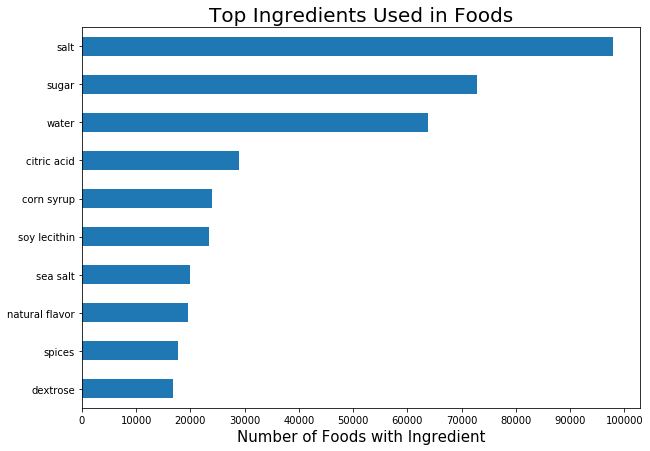

In [73]:
# building bar chart of top ingredients
plt.figure(figsize=(10, 7))
ing_vec_df.sum().sort_values(ascending=True).tail(10).plot(kind="barh")
plt.title("Top Ingredients Used in Foods", size=20)
plt.xlabel("Number of Foods with Ingredient", size=15)
plt.xticks(range(0, 100_001, 10_000));

This is a very interesting chart, showing that salt and sugar are the top two ingredients used in food products. 

## Sources

1. https://fortune.com/global500/2019/